# Generating embeddings

In [1]:
#TODO: remove after development 
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns

pd.set_option('display.max_columns', 5400)
pd.set_option('max_colwidth', 60)

## Loading data

In [4]:
import pickle

#seed_name = 'hair_dryer'
#seed_name = 'video_codec'
#seed_name = 'diesel'
seed_name = "contact_lens"
#seed_name = "contact_lens_us_c"
#seed_name = "3d_printer"

src_dir = "."
with open(src_dir + "/data/" + seed_name + '/terms_attributes.pkl', 'rb') as infile:
    seed = pickle.load(infile)
    
print(seed.shape)
seed.head()

(3225, 22)


,pub_num,publication_number,country_code,family_id,priority_date,title_text,abstract_text,claims_text,tokens,year,month,day,ipc_classes,first_letters,three_letters,four_letters,before_slash,references,referenced_by,raw_assignees,assignees,terms
0,4104187,US-4104187-A,US,24713901,19760412,Composition and method treating soft contact lenses at e...,Method and compositions are provided for elevated temper...,What is claimed is: \n \n 1. A soft lens therm...,"[composition, treating, soft, contact, lenses, elevated,...",1976,4,12,"[A61L12/14, C11D1/52, C11D1/66, C11D1/90, C11D10/02, C11...","[A, C, G]","[A61, C11, G02]","[A61L, C11D, G02C]","[A61L12, C11D1, C11D10, C11D17, C11D3, G02C13, G02C7]","[US-3171752-A, US-4013576-A, US-2089212-A, US-3888782-A,...","[US-4259202-A, US-2006241001-A1, US-4533399-A, US-467869...",[BARNES HIND PHARM INC],[BARNES HIND INC],"[physiologically acceptable, disinfecting cleaning, phys..."
1,6000534,US-6000534-A,US,24806490,19960816,Contact lens disinfecting device and disinfection system,The present invention provides a device for disinfecting...,I claim: \n \n 1. A device for disinfecting an...,"[contact, lens, disinfecting, device, disinfection, syst...",1996,8,16,"[A45C11/00, A61L12/12, A61L2/18, G02C13/00]","[A, G]","[A45, A61, G02]","[A45C, A61L, G02C]","[A45C11, A61L12, A61L2, G02C13]","[US-4750610-A, US-4889693-A, US-5143104-A, US-5353949-A,...",[],[ALLERGAN SALES INC],[ADVANCED CORNEAL SYSTEMS INC],"[lens holding, cap, internal surface, container cap, int..."
2,7281794,US-7281794-B2,US,25536666,20011116,Disposable ophthalmic lens,"An ophthalmic lens with high definition, wide field of v...",What is claimed and desired to be secured by Letters Pat...,"[disposable, ophthalmic, lens, ophthalmic, lens, high, d...",2001,11,16,"[A61B3/125, G02C7/04]","[A, G]","[A61, G02]","[A61B, G02C]","[A61B3, G02C7]","[US-6471396-B2, US-4921205-A, US-4613379-A, US-5706073-A...",[],[HEACOCK GREGORY L],[HEACOCK GREGORY L],"[image lens, lens image, holder, lens mounted, lens inte..."
3,8693104,US-8693104-B2,US,44651943,20100824,Lens with compound linear-convex meniscus wall,The present invention relates generally to an arcuate li...,The invention claimed is: \n \n 1. An optical ...,"[lens, compound, linear, convex, meniscus, wall, arcuate...",2010,8,24,"[G02B1/06, G02B3/12]",[G],[G02],[G02B],"[G02B1, G02B3]","[WO-2008062067-A1, US-7724444-B2, US-7311398-B2, WO-2004...",[],"[KERNICK EDWARD R, RIALL JAMES DANIEL, JOHNSON & JOHNSON...","[SNOOK SHARIKA, RIALL JAMES D, PUGH RANDALL B, OTTS DANI...","[curve lens, meniscus, optical lens, electrical charge, ..."
4,8215770,US-8215770-B2,US,40337739,20070223,Ophthalmic dynamic aperture,Embodiments of the present invention relate to an electr...,"1. An ophthalmic device, comprising:\n an electro-active...","[ophthalmic, dynamic, aperture, embodiments, electro, ac...",2007,2,23,"[A61F2/16, G02C7/04]","[A, G]","[A61, G02]","[A61F, G02C]","[A61F2, G02C7]","[US-6956682-B2, US-5608567-A, US-5963300-A, US-4904063-A...","[US-9535263-B2, US-9201250-B2, US-10203522-B2, US-954177...","[HADDOCK JOSHUA N, VAN HEUGTEN ANTHONY, KOKONASKI WILLIA...","[VAN HEUGTEN ANTHONY, HUNKELER JOHN, E A OPHTHALMICS, KO...","[electro active, electro, aperture, ophthalmic device, e..."


## Generating embeddings

In [5]:
from fiz_lernmodule.word2vec import Word2VecReader

w2v_loader = Word2VecReader(src_dir=src_dir)
w2v_model = w2v_loader.load_word_embeddings()

Load mappings from .\5.9m\vocab\vocab.csv
Load config from .\5.9m\vocab\config.csv
INFO:tensorflow:Restoring parameters from .\5.9m\checkpoints\5.9m_abstracts.ckpt-1325000


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict

class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
            
    def fit(self, X, y):
        return self 

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec.get_embedding(w) for w in words] 
                    or [np.zeros(300)], axis=0)
            for words in X
        ])

    
# and a tf-idf version of the same
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        
    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf, 
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
    
        return self
    
    def transform(self, X):
        return np.array([
                np.mean([self.word2vec.get_embedding(w) * self.word2weight[w]
                         for w in words] or
                        [np.zeros(300)], axis=0)
                for words in X
            ])

In [7]:
weighed_vectorizer = TfidfEmbeddingVectorizer(word2vec=w2v_model)
weighed_vectorizer.fit(seed.tokens, None)
weighed_embeddings = weighed_vectorizer.transform(seed.tokens)

In [8]:
average_word_weighed = pd.DataFrame(weighed_embeddings)
print(average_word_weighed.shape)
average_word_weighed.head(5)

(3225, 300)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,0.018317,-0.020692,0.001140,-0.047545,-0.053632,0.014068,-0.075592,-0.039524,0.035247,-0.081712,0.031543,0.063468,0.002660,-0.017891,0.077796,0.037241,0.020692,0.049872,-0.019199,0.063070,0.084919,0.033651,-0.026049,-0.025901,-0.035831,-0.052877,0.012185,0.078398,0.057633,-0.002868,0.023026,0.050893,0.049148,-0.062852,0.015819,-0.030742,-0.009109,0.000307,-0.010785,0.023136,-0.013049,0.045521,0.031173,-0.013923,-0.008361,-0.001690,0.061617,0.001240,0.011342,-0.002144,0.052598,-0.038938,-0.031685,-0.049183,-0.034690,-0.001073,0.039702,-0.032499,0.055816,0.121487,0.043997,0.006083,0.006232,0.044383,0.006080,0.010487,-0.057844,0.084791,-0.064845,-0.042841,-0.015428,-0.002461,0.038649,0.055409,0.029856,0.053338,0.034759,-0.017110,-0.084489,0.002858,0.064550,-0.084618,-0.057290,-0.031176,-0.048277,0.020433,-0.063156,-0.017329,0.081937,0.048583,0.017190,0.012384,0.016714,0.003133,0.038184,0.008788,0.036832,0.007372,0.851353,0.024235,-0.040153,0.042794,0.033907,0.025073,-0.019941,-0.014583,0.005645,-0.057974,0.008512,0.035664,-0.005142,0.186182,0.037376,0.043892,0.013151,0.011428,0.084501,-0.035303,-0.002225,0.023736,0.035305,0.054248,0.613891,0.011094,0.046226,-0.042282,-0.027685,0.002377,0.032696,0.015157,-0.012151,-0.069747,0.076545,-0.012013,0.100058,-0.062403,0.038208,0.008686,0.044620,-0.073393,-0.047253,0.031134,0.034914,-0.061011,-0.017587,-1.075211,0.053384,-0.025866,0.006484,0.012200,-0.154496,0.026894,-0.010574,0.027919,-0.044114,-0.018957,0.000539,0.021671,-0.048597,-0.018372,-0.004260,0.044259,-0.015664,-0.007786,0.274353,0.084129,0.016091,0.001760,-0.101674,0.050586,-0.054026,0.013773,-0.039405,-0.015442,0.028418,0.038701,-0.001726,0.029796,0.009132,0.021124,0.020136,-0.017272,0.094714,-0.035127,0.050329,-0.022151,-0.079485,-0.056652,-0.064062,-0.037138,-0.042615,0.066958,0.012025,-0.008646,0.078541,-0.041880,0.032362,-0.020332,-0.003883,-0.039675,0.033381,-0.077546,0.003409,0.008686,-0.013341,-0.046043,-0.028277,-0.000708,0.116462,0.010177,-0.186160,0.032388,-0.005375,0.081466,-0.031420,-0.109435,-0.006203,-0.035515,-0.075012,-0.045047,-0.042507,0.014811,-0.025199,0.025563,-0.011814,0.010370,0.116169,-0.055091,-0.041611,-0.019189,-0.290200,-0.014338,0.134467,-0.018742,-0.027060,-0.009209,-0.053049,0.074766,0.039629,0.023509,0.072533,0.017311,0.020124,-0.001717,-0.024148,-0.001615,0.056414,0.009132,0.016327,-0.071323,0.038631,-0.042726,-0.059668,0.057711,0.005961,-0.050389,-0.023340,-0.093984,-0.052112,0.036673,0.041246,-0.113411,0.014381,0.055084,0.165206,-0.060153,-0.086773,0.086610,0.011213,0.011758,0.043415,-0.069294,-0.022117,-0.051360,0.034359,0.020229,0.013837,0.045925,-0.016698,-1.164055,-0.005845,0.033190,0.071787,0.071667,0.054731,-0.045804,-0.014420,0.015771,-0.062842,0.000615,0.085044,0.038316,-0.101830,0.015709,-0.038018,0.044862,0.054441,0.023215,-0.012313,-0.014994
1,0.088572,0.015018,0.052334,-0.083456,0.011935,0.001410,-0.000838,-0

In [9]:
vectorizer = MeanEmbeddingVectorizer(word2vec=w2v_model)
vectorizer.fit(seed.tokens, None)
embeddings = vectorizer.transform(seed.tokens)

In [10]:
average_word = pd.DataFrame(embeddings)
print(average_word.shape)
average_word.head(5)

(3225, 300)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,0.006981,-0.004193,-0.005666,-0.005411,-0.011947,0.002677,-0.019062,-0.014917,0.009148,-0.016389,-0.001408,0.012553,-0.000167,-0.003662,0.017377,0.008430,0.001123,0.008907,-0.008800,0.009039,0.019087,0.009718,-0.003506,-0.007132,-0.002135,-0.011694,-0.001984,0.016545,0.015068,-0.000820,0.008087,0.007776,0.004358,-0.004757,0.000078,-0.006152,-0.002537,0.002424,0.001832,-0.002124,0.000538,0.012016,0.012483,-0.003954,0.002630,-0.004675,0.009100,0.002591,0.005836,-0.000258,0.009037,-0.008622,-0.002870,-0.009306,-0.011185,-0.000209,0.006193,-0.009248,0.015630,0.031712,0.002843,-0.003080,0.005999,0.008680,0.000163,0.003349,-0.011678,0.018511,-0.013404,-0.009393,-0.003334,-0.001500,-0.002836,0.008551,0.004978,0.014435,0.004337,-0.013943,-0.014840,-0.000345,0.013656,-0.018265,-0.011667,-0.003961,-0.010473,-0.007190,-0.010995,0.005143,0.021158,0.009116,0.003966,-0.003058,-0.000003,-0.002104,0.006328,0.004499,0.014177,-0.000389,0.209520,0.000310,-0.007844,0.006911,0.002548,0.011472,-0.001843,-0.003688,0.000064,-0.012499,0.002905,0.002557,0.003939,0.042336,0.009234,-0.005939,-0.003441,-0.001623,0.017810,-0.009044,0.003765,0.007809,0.004240,0.006373,0.159966,-0.003340,0.014993,-0.009195,-0.013068,-0.001461,0.007780,0.007616,-0.004413,-0.016568,0.011901,-0.002972,0.017731,-0.014289,0.010787,0.001592,0.010183,-0.013815,-0.008757,0.015462,0.005026,-0.019812,-0.005825,-0.262858,0.014589,0.000900,-0.000687,0.003283,-0.031734,-0.004295,-0.003151,0.003343,-0.013369,-0.004439,-0.002317,0.003589,-0.012657,-0.003131,-0.004777,0.010773,-0.006821,-0.000549,0.063014,0.017619,0.003381,0.002956,-0.024520,0.010886,-0.019114,0.003342,-0.008928,-0.005653,0.007811,0.005874,0.003693,0.002236,-0.003774,0.003875,0.000340,-0.001643,0.012807,-0.005578,0.007608,-0.007647,-0.016246,-0.010282,-0.013885,-0.007878,-0.005482,0.015316,-0.001513,-0.010135,0.012470,-0.013643,0.004373,-0.007958,0.001472,-0.014841,0.008697,-0.009360,0.001945,0.005466,-0.004737,-0.014988,0.000285,-0.002014,0.030273,0.002073,-0.032835,0.007376,-0.004964,0.010837,-0.003956,-0.010816,0.001704,-0.008210,-0.007403,-0.007580,-0.002475,0.010086,-0.009860,-0.000511,-0.002119,-0.003487,0.024119,-0.016815,-0.004301,0.003728,-0.064478,-0.005372,0.030241,-0.005508,-0.005233,-0.022806,-0.009870,0.008732,0.008043,0.005607,0.013842,0.009619,0.006270,0.002665,-0.005339,-0.001094,0.010788,0.003198,0.008060,-0.017130,0.010774,-0.008239,-0.011040,0.007871,-0.001648,-0.003133,-0.003606,-0.017493,-0.011563,0.006767,0.000848,-0.021756,0.005638,0.004579,0.036995,-0.006416,-0.013387,0.013009,0.003763,0.008565,0.006705,-0.020690,-0.007045,-0.008629,0.003095,0.007604,0.004868,0.005036,0.001930,-0.339793,-0.000890,0.020240,0.006656,0.012807,0.005482,-0.004811,-0.006545,0.004705,-0.018841,0.004002,0.017199,0.006885,-0.033949,-0.002795,-0.002830,0.006744,0.014182,-0.001344,-0.001442,0.001323
1,0.023206,-0.001578,0.013448,-0.018178,0.003754,-0.0044

In [11]:
import os

if not os.path.isdir(src_dir + "/data/" + seed_name + "/semantic"):
    os.mkdir(src_dir + "/data/" + seed_name + "/semantic")

with open(src_dir + "/data/" + seed_name + "/semantic/average_word_embedding.pkl", 'wb') as outfile:
    pickle.dump(average_word, outfile, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(src_dir + "/data/" + seed_name + "/semantic/weighed_word_embedding.pkl", 'wb') as outfile:
    pickle.dump(average_word_weighed, outfile, protocol=pickle.HIGHEST_PROTOCOL)

### TSNE with averaged word embeddings

In [12]:
from sklearn.manifold import TSNE

tsne300 = TSNE(metric='cosine', random_state=42)
#tsne300 = TSNE(metric='euclidean', random_state=42)

In [13]:
%%time

from fiz_lernmodule.visualization_landscaping import EmbeddingVisualizer

#ev300 = EmbeddingVisualizer(tsne300, average_word, seed)
ev300 = EmbeddingVisualizer(tsne300, average_word_weighed, seed)

Fit  TSNE(angle=0.5, early_exaggeration=12.0, init='random', learning_rate=200.0,
   method='barnes_hut', metric='cosine', min_grad_norm=1e-07,
   n_components=2, n_iter=1000, n_iter_without_progress=300,
   perplexity=30.0, random_state=42, verbose=0)
EmbeddingVisualizer initialized
Wall time: 34.5 s


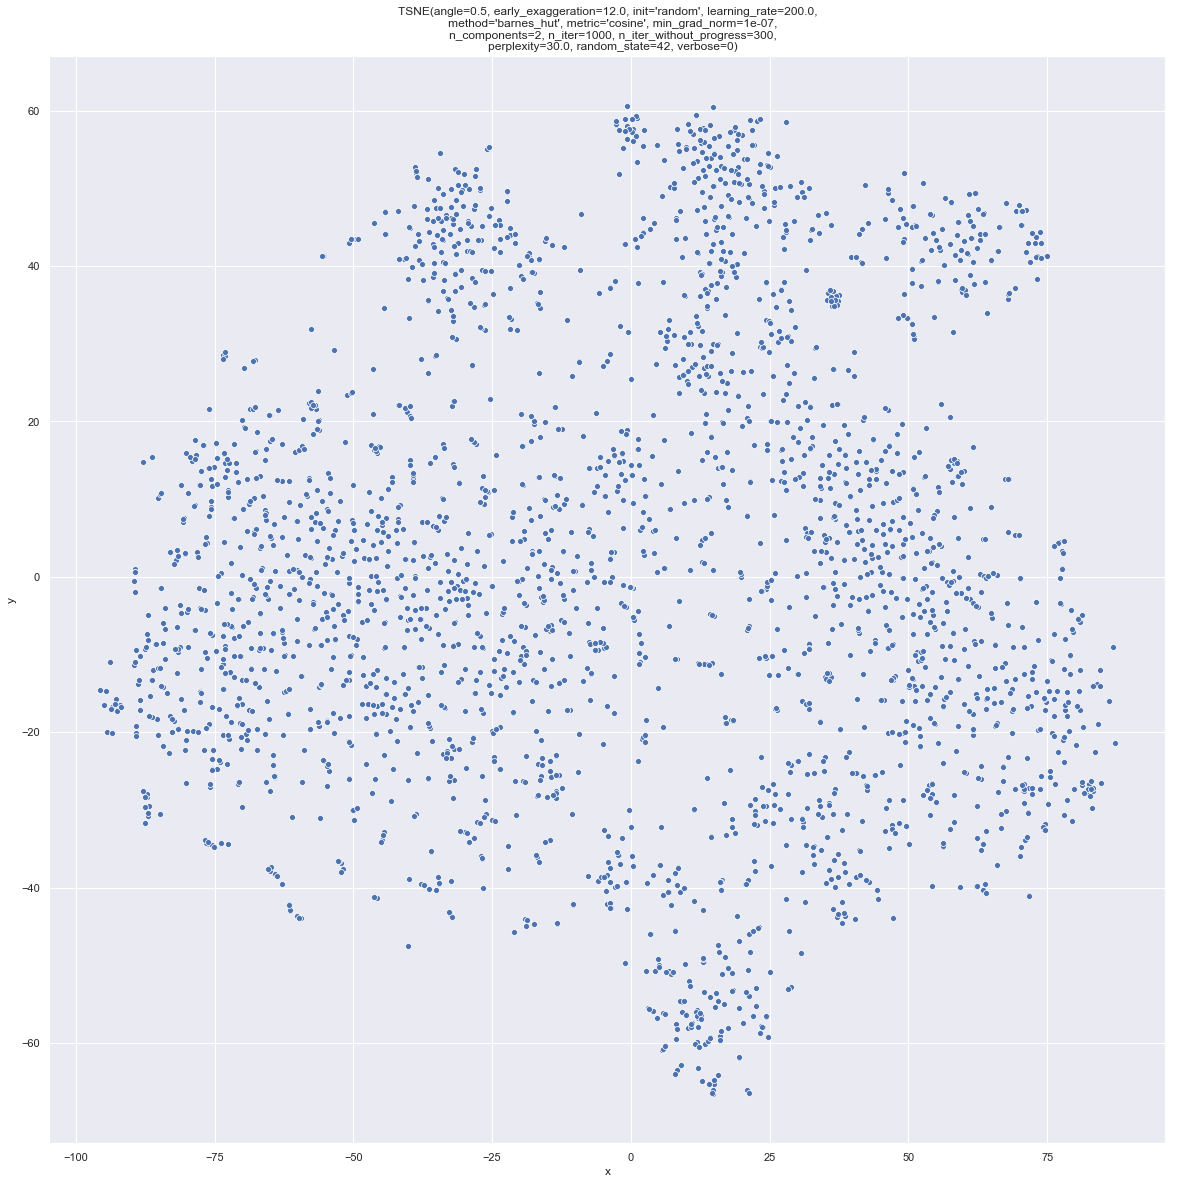

In [14]:
ev300.plot_embeddings(detailed=False, label=False)

In [15]:
coords = pd.DataFrame.from_records(tsne300.embedding_, columns=['x', 'y'], index=seed.index)

result = seed.merge(coords, left_index=True, right_index=True)
result.head()

,pub_num,publication_number,country_code,family_id,priority_date,title_text,abstract_text,claims_text,tokens,year,month,day,ipc_classes,first_letters,three_letters,four_letters,before_slash,references,referenced_by,raw_assignees,assignees,terms,x,y
0,4104187,US-4104187-A,US,24713901,19760412,Composition and method treating soft contact lenses at e...,Method and compositions are provided for elevated temper...,What is claimed is: \n \n 1. A soft lens therm...,"[composition, treating, soft, contact, lenses, elevated,...",1976,4,12,"[A61L12/14, C11D1/52, C11D1/66, C11D1/90, C11D10/02, C11...","[A, C, G]","[A61, C11, G02]","[A61L, C11D, G02C]","[A61L12, C11D1, C11D10, C11D17, C11D3, G02C13, G02C7]","[US-3171752-A, US-4013576-A, US-2089212-A, US-3888782-A,...","[US-4259202-A, US-2006241001-A1, US-4533399-A, US-467869...",[BARNES HIND PHARM INC],[BARNES HIND INC],"[physiologically acceptable, disinfecting cleaning, phys...",-35.054203,47.442360
1,6000534,US-6000534-A,US,24806490,19960816,Contact lens disinfecting device and disinfection system,The present invention provides a device for disinfecting...,I claim: \n \n 1. A device for disinfecting an...,"[contact, lens, disinfecting, device, disinfection, syst...",1996,8,16,"[A45C11/00, A61L12/12, A61L2/18, G02C13/00]","[A, G]","[A45, A61, G02]","[A45C, A61L, G02C]","[A45C11, A61L12, A61L2, G02C13]","[US-4750610-A, US-4889693-A, US-5143104-A, US-5353949-A,...",[],[ALLERGAN SALES INC],[ADVANCED CORNEAL SYSTEMS INC],"[lens holding, cap, internal surface, container cap, int...",12.922727,57.721729
2,7281794,US-7281794-B2,US,25536666,20011116,Disposable ophthalmic lens,"An ophthalmic lens with high definition, wide field of v...",What is claimed and desired to be secured by Letters Pat...,"[disposable, ophthalmic, lens, ophthalmic, lens, high, d...",2001,11,16,"[A61B3/125, G02C7/04]","[A, G]","[A61, G02]","[A61B, G02C]","[A61B3, G02C7]","[US-6471396-B2, US-4921205-A, US-4613379-A, US-5706073-A...",[],[HEACOCK GREGORY L],[HEACOCK GREGORY L],"[image lens, lens image, holder, lens mounted, lens inte...",34.833977,-25.016047
3,8693104,US-8693104-B2,US,44651943,20100824,Lens with compound linear-convex meniscus wall,The present invention relates generally to an arcuate li...,The invention claimed is: \n \n 1. An optical ...,"[lens, compound, linear, convex, meniscus, wall, arcuate...",2010,8,24,"[G02B1/06, G02B3/12]",[G],[G02],[G02B],"[G02B1, G02B3]","[WO-2008062067-A1, US-7724444-B2, US-7311398-B2, WO-2004...",[],"[KERNICK EDWARD R, RIALL JAMES DANIEL, JOHNSON & JOHNSON...","[SNOOK SHARIKA, RIALL JAMES D, PUGH RANDALL B, OTTS DANI...","[curve lens, meniscus, optical lens, electrical charge, ...",37.324848,35.504322
4,8215770,US-8215770-B2,US,40337739,20070223,Ophthalmic dynamic aperture,Embodiments of the present invention relate to an electr...,"1. An ophthalmic device, comprising:\n an electro-active...","[ophthalmic, dynamic, aperture, embodiments, electro, ac...",2007,2,23,"[A61F2/16, G02C7/04]","[A, G]","[A61, G02]","[A61F, G02C]","[A61F2, G02C7]","[US-6956682-B2, US-5608567-A, US-5963300-A, US-4904063-A...","[US-9535263-B2, US-9201250-B2, US-10203522-B2, US-954177...","[HADDOCK JOSHUA N, VAN HEUGTEN ANTHONY, KOKONASKI WILLIA...","[VAN HEUGTEN ANTHONY, HUNKELER JOHN, E A OPHTHALMICS, KO...","[electro active, electro, aperture, ophthalmic device, e...",50.609318,37.847672


In [17]:
import os

if not os.path.isdir(src_dir + "/data/" + seed_name + "/semantic"):
    os.mkdir(src_dir + "/data/" + seed_name + "/semantic")

with open(src_dir + "/data/" + seed_name + "/semantic/tsne.pkl", 'wb') as outfile:
    pickle.dump(result, outfile, protocol=pickle.HIGHEST_PROTOCOL)

MemoryError: 

In [18]:
result.drop(columns=["tokens"], inplace=True)
result["terms"] = result["terms"].apply(lambda x: x[:15])
result.head()

,pub_num,publication_number,country_code,family_id,priority_date,title_text,abstract_text,claims_text,year,month,day,ipc_classes,first_letters,three_letters,four_letters,before_slash,references,referenced_by,raw_assignees,assignees,terms,x,y
0,4104187,US-4104187-A,US,24713901,19760412,Composition and method treating soft contact lenses at e...,Method and compositions are provided for elevated temper...,What is claimed is: \n \n 1. A soft lens therm...,1976,4,12,"[A61L12/14, C11D1/52, C11D1/66, C11D1/90, C11D10/02, C11...","[A, C, G]","[A61, C11, G02]","[A61L, C11D, G02C]","[A61L12, C11D1, C11D10, C11D17, C11D3, G02C13, G02C7]","[US-3171752-A, US-4013576-A, US-2089212-A, US-3888782-A,...","[US-4259202-A, US-2006241001-A1, US-4533399-A, US-467869...",[BARNES HIND PHARM INC],[BARNES HIND INC],"[physiologically acceptable, disinfecting cleaning, phys...",-35.054203,47.442360
1,6000534,US-6000534-A,US,24806490,19960816,Contact lens disinfecting device and disinfection system,The present invention provides a device for disinfecting...,I claim: \n \n 1. A device for disinfecting an...,1996,8,16,"[A45C11/00, A61L12/12, A61L2/18, G02C13/00]","[A, G]","[A45, A61, G02]","[A45C, A61L, G02C]","[A45C11, A61L12, A61L2, G02C13]","[US-4750610-A, US-4889693-A, US-5143104-A, US-5353949-A,...",[],[ALLERGAN SALES INC],[ADVANCED CORNEAL SYSTEMS INC],"[lens holding, cap, internal surface, container cap, int...",12.922727,57.721729
2,7281794,US-7281794-B2,US,25536666,20011116,Disposable ophthalmic lens,"An ophthalmic lens with high definition, wide field of v...",What is claimed and desired to be secured by Letters Pat...,2001,11,16,"[A61B3/125, G02C7/04]","[A, G]","[A61, G02]","[A61B, G02C]","[A61B3, G02C7]","[US-6471396-B2, US-4921205-A, US-4613379-A, US-5706073-A...",[],[HEACOCK GREGORY L],[HEACOCK GREGORY L],"[image lens, lens image, holder, lens mounted, lens inte...",34.833977,-25.016047
3,8693104,US-8693104-B2,US,44651943,20100824,Lens with compound linear-convex meniscus wall,The present invention relates generally to an arcuate li...,The invention claimed is: \n \n 1. An optical ...,2010,8,24,"[G02B1/06, G02B3/12]",[G],[G02],[G02B],"[G02B1, G02B3]","[WO-2008062067-A1, US-7724444-B2, US-7311398-B2, WO-2004...",[],"[KERNICK EDWARD R, RIALL JAMES DANIEL, JOHNSON & JOHNSON...","[SNOOK SHARIKA, RIALL JAMES D, PUGH RANDALL B, OTTS DANI...","[curve lens, meniscus, optical lens, electrical charge, ...",37.324848,35.504322
4,8215770,US-8215770-B2,US,40337739,20070223,Ophthalmic dynamic aperture,Embodiments of the present invention relate to an electr...,"1. An ophthalmic device, comprising:\n an electro-active...",2007,2,23,"[A61F2/16, G02C7/04]","[A, G]","[A61, G02]","[A61F, G02C]","[A61F2, G02C7]","[US-6956682-B2, US-5608567-A, US-5963300-A, US-4904063-A...","[US-9535263-B2, US-9201250-B2, US-10203522-B2, US-954177...","[HADDOCK JOSHUA N, VAN HEUGTEN ANTHONY, KOKONASKI WILLIA...","[VAN HEUGTEN ANTHONY, HUNKELER JOHN, E A OPHTHALMICS, KO...","[electro active, electro, aperture, ophthalmic device, e...",50.609318,37.847672


In [19]:
result.to_json('../demo/data/semantic/' + seed_name + '.json', orient="records")